# Mobile Customer Churn

In this Portfolio task you will work with some (fake but realistic) data on Mobile Customer Churn.  Churn is where
a customer leaves the mobile provider.   The goal is to build a simple predictive model to predict churn from available features. 

The data was generated (by Hume Winzar at Macquarie) based on a real dataset provided by Optus.  The data is simulated but the column headings are the same. (Note that I'm not sure if all of the real relationships in this data are preserved so you need to be cautious in interpreting the results of your analysis here).  

The data is provided in file `MobileCustomerChurn.csv` and column headings are defined in a file `MobileChurnDataDictionary.csv` (store these in the `files` folder in your project).

Your high level goal in this notebook is to try to build and evaluate a __predictive model for churn__ - predict the value of the CHURN_IND field in the data from some of the other fields.  Note that the three `RECON` fields should not be used as they indicate whether the customer reconnected after having churned. 

__Note:__ you are not being evaluated on the _accuracy_ of the model but on the _process_ that you use to generate it.  You can use a simple model such as Logistic Regression for this task or try one of the more advanced methods covered in recent weeks.  Explore the data, build a model using a selection of features and then do some work on finding out which features provide the most accurate results.  

In [62]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, KFold, GridSearchCV, cross_val_score, cross_val_predict
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.feature_selection import RFE
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
%matplotlib inline 

In [63]:
churn = pd.read_csv("files/MobileCustomerChurn.csv", na_values=["NA", "#VALUE!"], index_col='INDEX')
churn.head()

,CUST_ID,ACCOUNT_TENURE,ACCT_CNT_SERVICES,AGE,CFU,SERVICE_TENURE,PLAN_ACCESS_FEE,BYO_PLAN_STATUS,PLAN_TENURE,MONTHS_OF_CONTRACT_REMAINING,...,CONTRACT_STATUS,PREV_CONTRACT_DURATION,HANDSET_USED_BRAND,CHURN_IND,MONTHLY_SPEND,COUNTRY_METRO_REGION,STATE,RECON_SMS_NEXT_MTH,RECON_TELE_NEXT_MTH,RECON_EMAIL_NEXT_MTH
INDEX,,,,,,,,,,,,,,,,,,,,,
1,1,46,1,30.0,CONSUMER,46,54.54,NON BYO,15,0,...,OFF-CONTRACT,24,SAMSUNG,1,61.40,COUNTRY,WA,NaN,NaN,NaN
2,2,60,3,55.0,CONSUMER,59,54.54,NON BYO,5,0,...,OFF-CONTRACT,24,APPLE,1,54.54,METRO,NSW,NaN,NaN,NaN
3,5,65,1,29.0,CONSUMER,65,40.90,BYO,15,0,...,OFF-CONTRACT,12,APPLE,1,2.50,COUNTRY,WA,NaN,NaN,NaN
4,6,31,1,51.0,CONSUMER,31,31.81,NON BYO,31,0,...,OFF-CONTRACT,24,APPLE,1,6.48,COUNTRY,VIC,NaN,NaN,NaN
5,8,95,1,31.0,CONSUMER,95,54.54,NON BYO,0,0,...,OFF-CONTRACT,24,APPLE,1,100.22,METRO,NSW,NaN,NaN,NaN


# Data Exploration

The following code will explore the data contained in churn. 

It will be used to gain basic insight into the data and determine its characteistics and whether or not it will need to be manipulated for the prodictive model. 

In [64]:
churn.describe() 

,CUST_ID,ACCOUNT_TENURE,ACCT_CNT_SERVICES,AGE,SERVICE_TENURE,PLAN_ACCESS_FEE,PLAN_TENURE,MONTHS_OF_CONTRACT_REMAINING,LAST_FX_CONTRACT_DURATION,PREV_CONTRACT_DURATION,CHURN_IND,MONTHLY_SPEND,RECON_SMS_NEXT_MTH,RECON_TELE_NEXT_MTH,RECON_EMAIL_NEXT_MTH
count,46206.000000,46206.000000,46206.000000,46130.000000,46206.000000,46206.000000,46206.000000,46206.000000,46206.000000,46206.000000,46206.000000,46206.000000,28416.000000,28416.000000,28416.000000
mean,42335.196879,45.874627,1.555707,41.411836,50.318617,51.364858,10.846708,8.237112,20.349825,15.249968,0.385015,75.188029,0.014640,0.191125,0.007038
std,22100.432751,33.077927,0.835529,15.263726,51.925537,20.855419,9.769887,8.341476,8.034631,10.982958,0.486604,73.519041,0.120108,0.393194,0.083600
min,1.000000,0.000000,1.000000,-4.000000,0.000000,8.180000,0.000000,0.000000,0.000000,0.000000,0.000000,1.020000,0.000000,0.000000,0.000000
25%,24951.750000,14.000000,1.000000,28.000000,11.000000,36.360000,3.000000,0.000000,24.000000,0.000000,0.000000,36.360000,0.000000,0.000000,0.000000
50%,43261.000000,44.000000,1.000000,40.000000,35.000000,54.540000,8.000000,7.000000,24.000000,24.000000,0.000000,54.540000,0.000000,0.000000,0.000000
75%,61132.750000,77.000000,2.000000,52.000000,69.000000,72.720000,16.000000,16.000000,24.000000,24.000000,1.000000,84.530000,0.000000,0.000000,0.000000
max,79500.000000,120.000000,4.000000,116.000000,259.000000,234.540000,147.000000,24.000000,36.000000,36.000000,1.000000,1965.890000,1.000000,1.000000,1.000000


In [65]:
churn.shape

(46206, 21)

### Predictive Variables

In [66]:
set(churn['CHURN_IND'])

{0, 1}

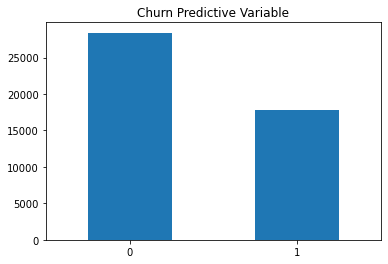

In [67]:
churn['CHURN_IND'].value_counts().plot(kind='bar', rot=0)
temp = plt.title('Churn Predictive Variable')

As per above there are two distinct values that will be used for the prediction. The values being used are 1 and 0. 

Notably, spread of the pridictive variables are reasonable and will be used in the model as is. 

# Data Preparation

Before the model is created, the bellow code will explore important features and prepare the data for the model

Firstly, unnecessary data frame columns will be dropped as they are unusable.

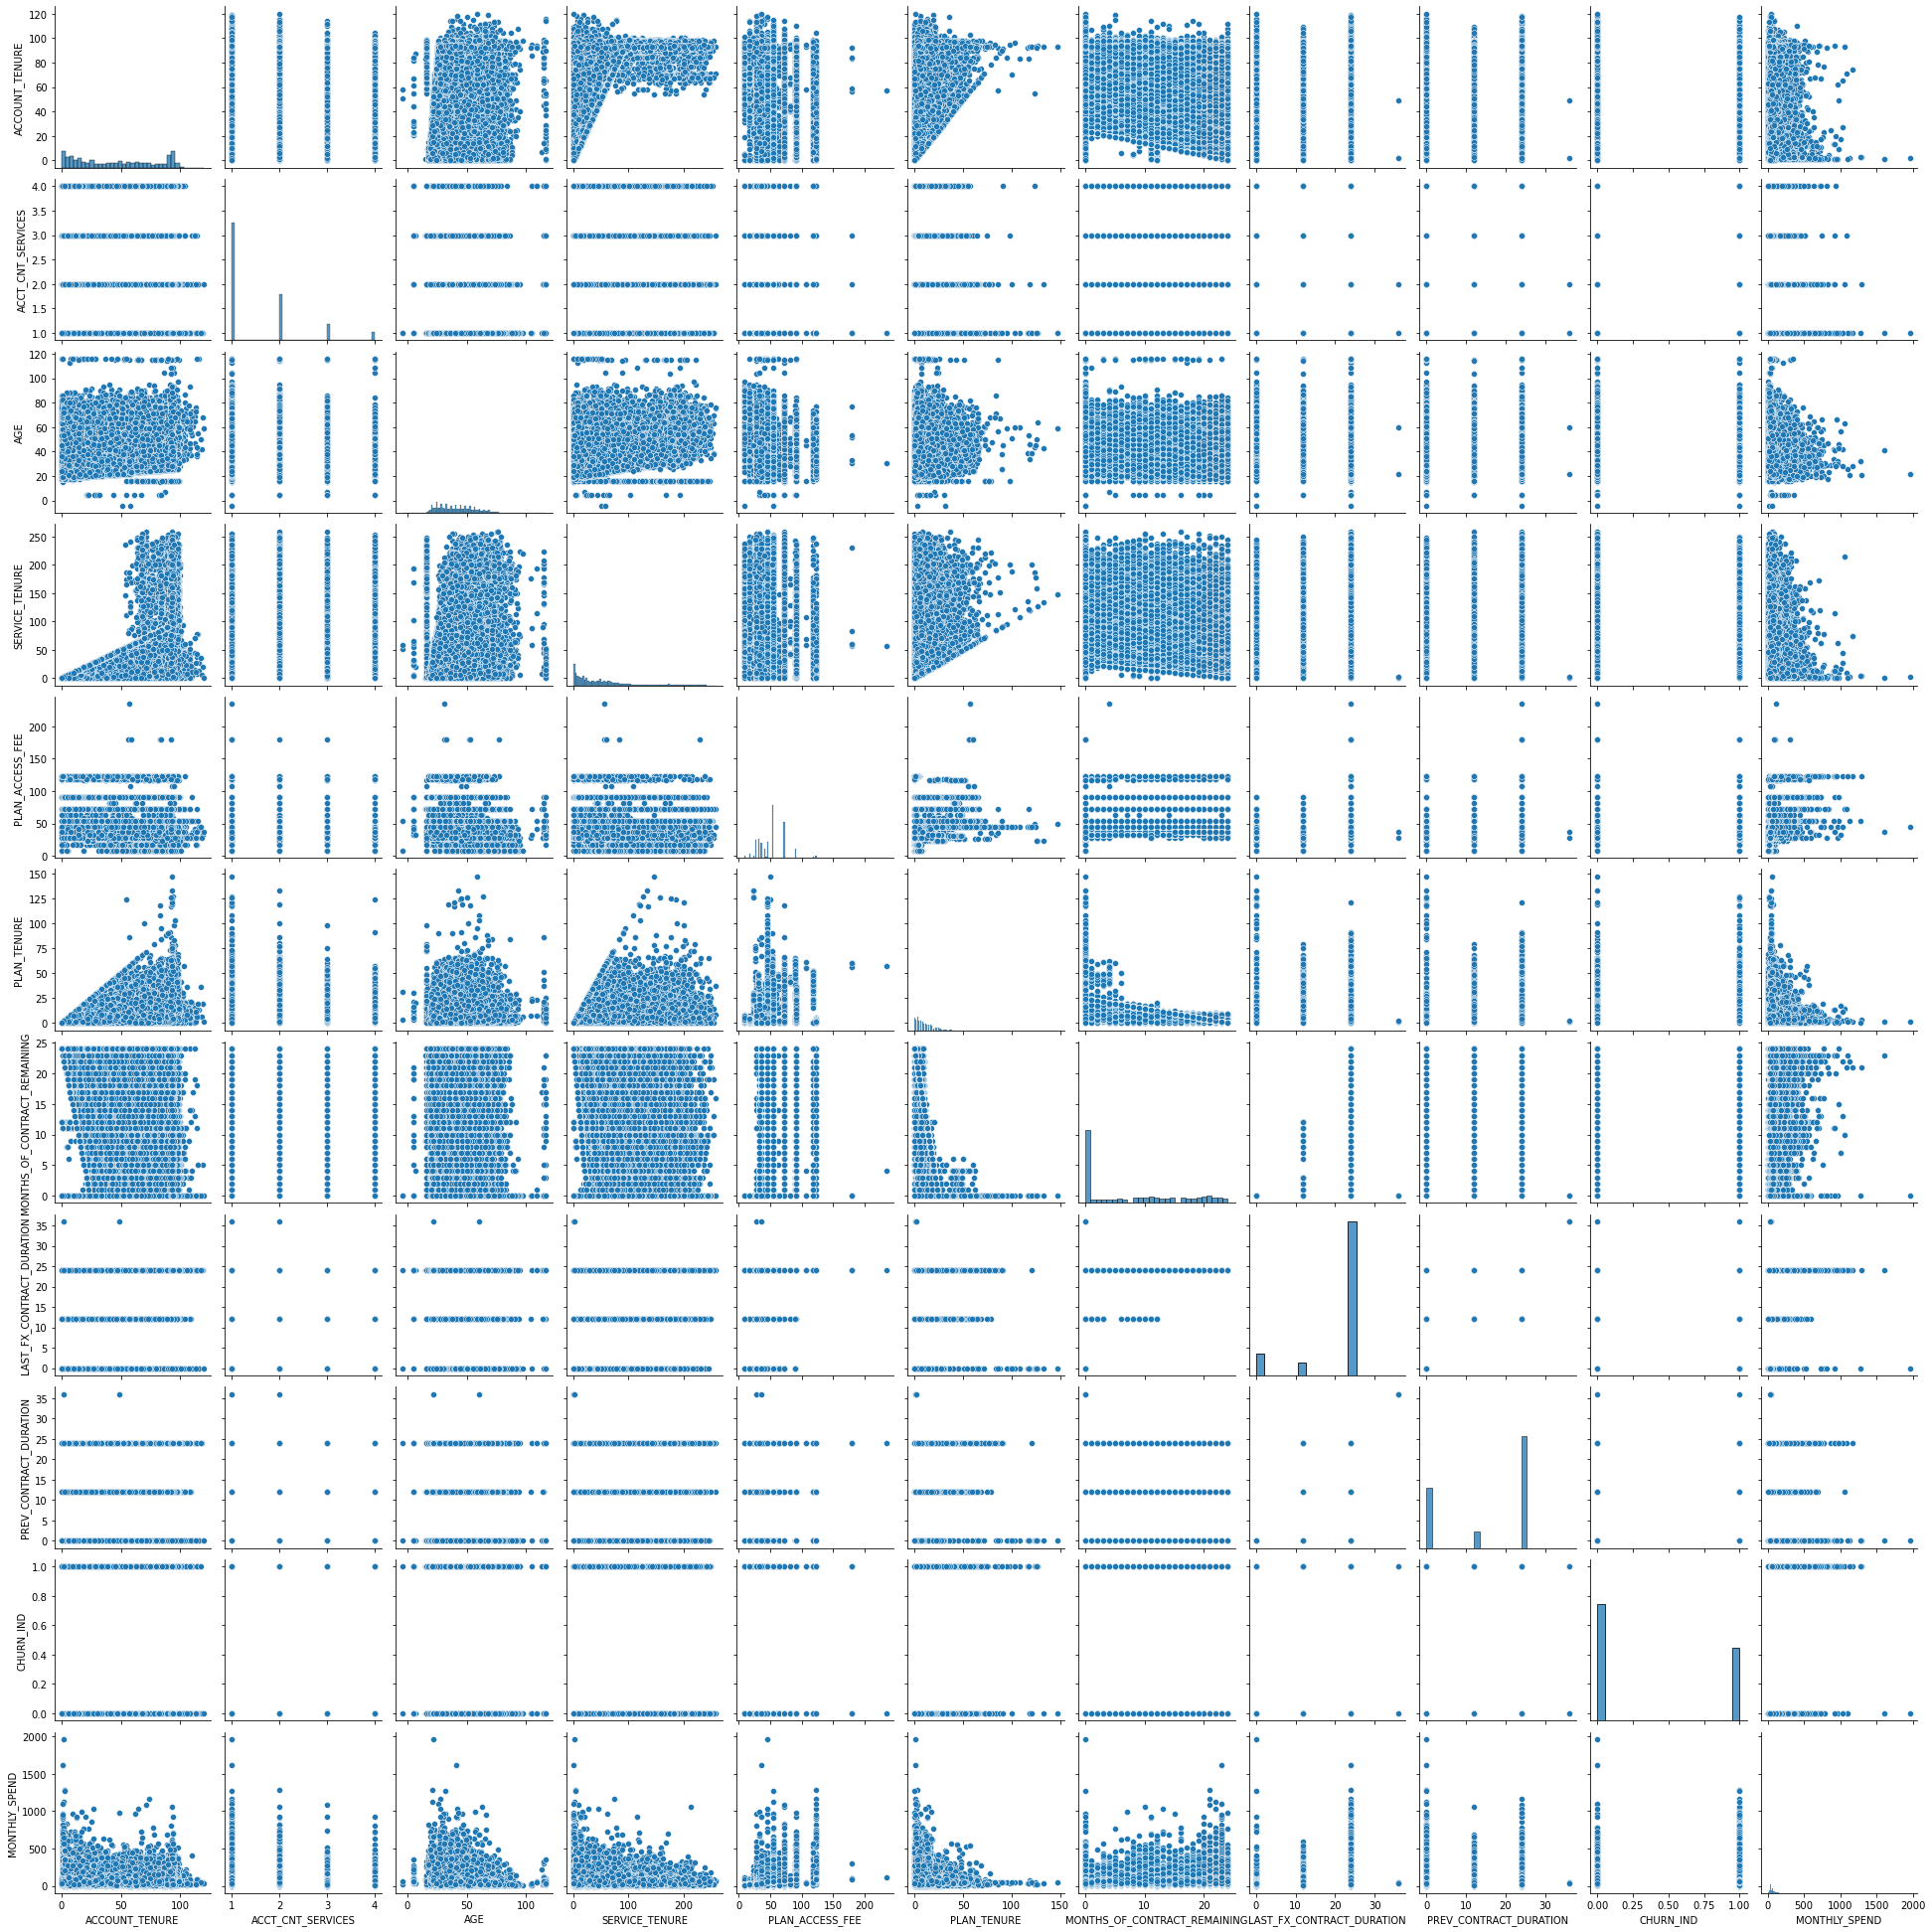

In [68]:
churn.drop(['CUST_ID', 'RECON_SMS_NEXT_MTH', 'RECON_TELE_NEXT_MTH', 'RECON_EMAIL_NEXT_MTH'], axis=1, inplace=True)
sns.pairplot(churn)

### Null Values

To ensure the model can be created correctly, the data will be explored for null and missing values. The outcome will determine how any missing values will be handled

In [8]:
churn.isna().sum()

ACCOUNT_TENURE                   0
ACCT_CNT_SERVICES                0
AGE                             76
CFU                              0
SERVICE_TENURE                   0
PLAN_ACCESS_FEE                  0
BYO_PLAN_STATUS                  0
PLAN_TENURE                      0
MONTHS_OF_CONTRACT_REMAINING     0
LAST_FX_CONTRACT_DURATION        0
CONTRACT_STATUS                  0
PREV_CONTRACT_DURATION           0
HANDSET_USED_BRAND               0
CHURN_IND                        0
MONTHLY_SPEND                    0
COUNTRY_METRO_REGION             1
STATE                            1
dtype: int64

In [9]:
churn.shape

(46206, 17)

In [10]:
churn.dropna(axis=0, inplace=True)
churn.shape

(46129, 17)

In [11]:
churn.isna().sum()

ACCOUNT_TENURE                  0
ACCT_CNT_SERVICES               0
AGE                             0
CFU                             0
SERVICE_TENURE                  0
PLAN_ACCESS_FEE                 0
BYO_PLAN_STATUS                 0
PLAN_TENURE                     0
MONTHS_OF_CONTRACT_REMAINING    0
LAST_FX_CONTRACT_DURATION       0
CONTRACT_STATUS                 0
PREV_CONTRACT_DURATION          0
HANDSET_USED_BRAND              0
CHURN_IND                       0
MONTHLY_SPEND                   0
COUNTRY_METRO_REGION            0
STATE                           0
dtype: int64

Since there are very few missing values, dropping the rows containing missing values is a viable approach to preparing the data.

### Feature Encoding

The Logistic Regression Model requires that all data types must be numerical. As such, finding and encoding any non-numerical data with unique values will ensure a model can be created. 

In [12]:
churn.info() 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 46129 entries, 1 to 46206
Data columns (total 17 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   ACCOUNT_TENURE                46129 non-null  int64  
 1   ACCT_CNT_SERVICES             46129 non-null  int64  
 2   AGE                           46129 non-null  float64
 3   CFU                           46129 non-null  object 
 4   SERVICE_TENURE                46129 non-null  int64  
 5   PLAN_ACCESS_FEE               46129 non-null  float64
 6   BYO_PLAN_STATUS               46129 non-null  object 
 7   PLAN_TENURE                   46129 non-null  int64  
 8   MONTHS_OF_CONTRACT_REMAINING  46129 non-null  int64  
 9   LAST_FX_CONTRACT_DURATION     46129 non-null  int64  
 10  CONTRACT_STATUS               46129 non-null  object 
 11  PREV_CONTRACT_DURATION        46129 non-null  int64  
 12  HANDSET_USED_BRAND            46129 non-null  object 
 13  C

In [13]:
catagorical_feat = churn.select_dtypes(include=['object']).columns.tolist()
print('Number of catagorical features: ', len(catagorical_feat))
print('Features: ' ,catagorical_feat)

Number of catagorical features:  6
Features:  ['CFU', 'BYO_PLAN_STATUS', 'CONTRACT_STATUS', 'HANDSET_USED_BRAND', 'COUNTRY_METRO_REGION', 'STATE']


The above variables are non-numeric and will need to be encoded into numeric values.

The following code will determine the values cardinality. Using the function encodeData(), these values will be encoded with a unique value

In [14]:
for feat in catagorical_feat:
    value = len(churn[feat].unique())
    print('Cardinality of {} are: {}'.format(feat, value))

Cardinality of CFU are: 2
Cardinality of BYO_PLAN_STATUS are: 2
Cardinality of CONTRACT_STATUS are: 3
Cardinality of HANDSET_USED_BRAND are: 6
Cardinality of COUNTRY_METRO_REGION are: 2
Cardinality of STATE are: 8


In [15]:
def encodeData(feat):
        map_dict = {}
        values = list(churn[feat].unique())
        for i in range(len(values)):
            map_dict[values[i]] = i
        return map_dict

for feat in catagorical_feat:
    churn[feat].replace(encodeData(feat), inplace=True)

In [16]:
for feat in catagorical_feat:
    value = len(churn[feat].unique())
    print('Cardinality of {} are: {}'.format(feat, value))

Cardinality of CFU are: 2
Cardinality of BYO_PLAN_STATUS are: 2
Cardinality of CONTRACT_STATUS are: 3
Cardinality of HANDSET_USED_BRAND are: 6
Cardinality of COUNTRY_METRO_REGION are: 2
Cardinality of STATE are: 8


In [17]:
churn.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 46129 entries, 1 to 46206
Data columns (total 17 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   ACCOUNT_TENURE                46129 non-null  int64  
 1   ACCT_CNT_SERVICES             46129 non-null  int64  
 2   AGE                           46129 non-null  float64
 3   CFU                           46129 non-null  int64  
 4   SERVICE_TENURE                46129 non-null  int64  
 5   PLAN_ACCESS_FEE               46129 non-null  float64
 6   BYO_PLAN_STATUS               46129 non-null  int64  
 7   PLAN_TENURE                   46129 non-null  int64  
 8   MONTHS_OF_CONTRACT_REMAINING  46129 non-null  int64  
 9   LAST_FX_CONTRACT_DURATION     46129 non-null  int64  
 10  CONTRACT_STATUS               46129 non-null  int64  
 11  PREV_CONTRACT_DURATION        46129 non-null  int64  
 12  HANDSET_USED_BRAND            46129 non-null  int64  
 13  C

In [18]:
churn.head()

,ACCOUNT_TENURE,ACCT_CNT_SERVICES,AGE,CFU,SERVICE_TENURE,PLAN_ACCESS_FEE,BYO_PLAN_STATUS,PLAN_TENURE,MONTHS_OF_CONTRACT_REMAINING,LAST_FX_CONTRACT_DURATION,CONTRACT_STATUS,PREV_CONTRACT_DURATION,HANDSET_USED_BRAND,CHURN_IND,MONTHLY_SPEND,COUNTRY_METRO_REGION,STATE
INDEX,,,,,,,,,,,,,,,,,
1,46,1,30.0,0,46,54.54,0,15,0,24,0,24,0,1,61.40,0,0
2,60,3,55.0,0,59,54.54,0,5,0,24,0,24,1,1,54.54,1,1
3,65,1,29.0,0,65,40.90,1,15,0,12,0,12,1,1,2.50,0,0
4,31,1,51.0,0,31,31.81,0,31,0,24,0,24,1,1,6.48,0,2
5,95,1,31.0,0,95,54.54,0,0,0,24,0,24,1,1,100.22,1,1


As seen above, the non-numeric values have now been encoded with a unique numeric value and no data has been lost

### Scaling

The box plot below shows that the spread of data is quite significant. Especially the column 'MONTHLY_SPEND'. Therefore the data will be scaled using sklearn's MinMaxScaler. 

The scaler will transform features between 0 and 1 to ensure no feature dominates the Logistic Regression algorithm

The scaler uses the following formula to transform features:
```
X_std = (X - X.min(axis=0)) / (X.max(axis=0) - X.min(axis=0)) 

X_scaled = X_std * (max - min) + min 
```

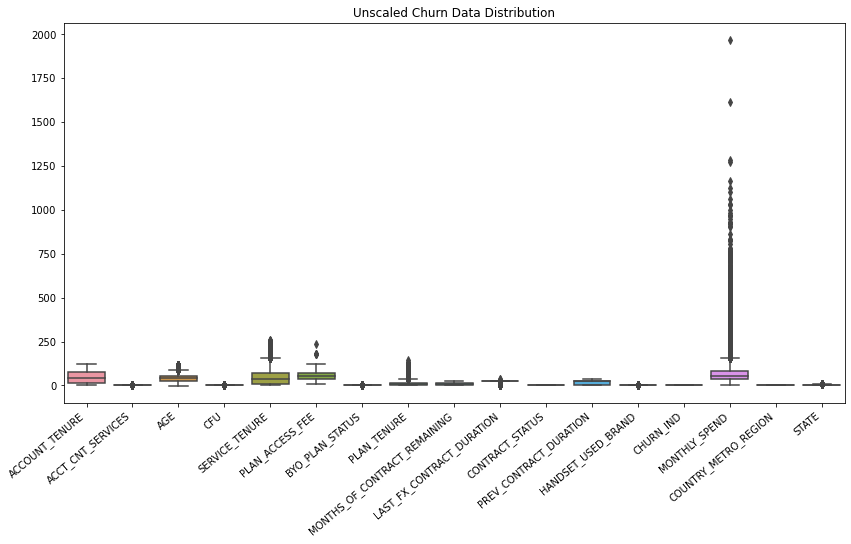

In [19]:
plt.figure(figsize=(14, 7))
ax = sns.boxplot(data=churn)
ax.set_title('Unscaled Churn Data Distribution')
temp = ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")

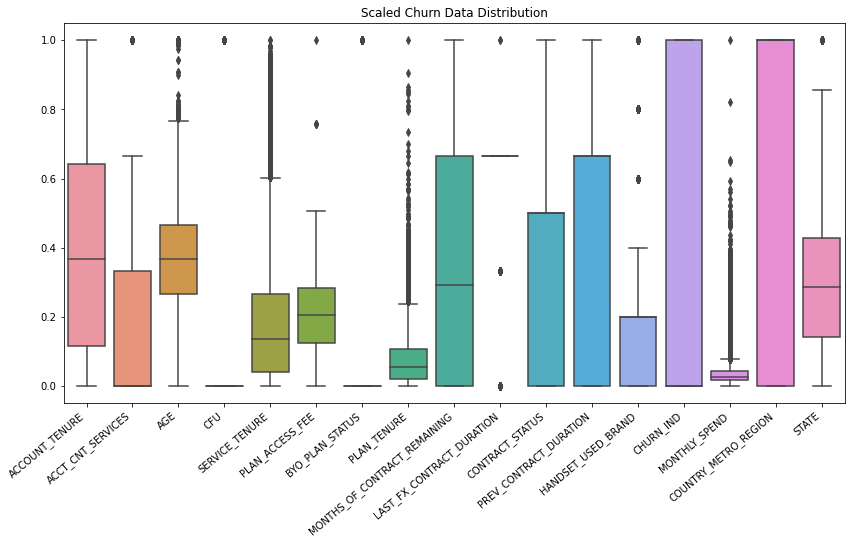

In [20]:
plt.figure(figsize = (14, 7))
df_scaled = MinMaxScaler()
churn = pd.DataFrame(df_scaled.fit_transform(churn), index=churn.index, columns=churn.columns)
ax = sns.boxplot(data = churn)
ax.set_title('Scaled Churn Data Distribution')
temp = ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")

# Predictive Model's 

Using the now prepared data, the following models will be created and evaluated: 

1. Logistic Regression
2. K Nearest Neighbors
3. Random Forest Classifier 

## Train, Test Split

The Logistic Regression model training will use sklearn's train_test_split function. 

The test size will be 20% of the total size and the prediction variable will be 'CHURN_IND'.

In [21]:
X_all = churn.drop(['CHURN_IND'], axis=1)
y_all = churn['CHURN_IND']

train, test = train_test_split(churn, test_size=0.2, random_state=42)
X_train = train.drop(['CHURN_IND'], axis=1)
y_train = train['CHURN_IND']
X_test = test.drop(['CHURN_IND'], axis=1)
y_test = test['CHURN_IND']

In [22]:
print('All X: ', X_all.shape)
print('All y: ', y_all.shape)
print('Train X: ', X_train.shape)
print('Train y: ', y_train.shape)
print('Test X: ', X_test.shape)
print('Test y: ', y_test.shape)

All X:  (46129, 16)
All y:  (46129,)
Train X:  (36903, 16)
Train y:  (36903,)
Test X:  (9226, 16)
Test y:  (9226,)


## Logistic Regression Model

The first model will be a Logistic Regression model. The model is created and evaluated with the following steps:

1. Initial creation and Accuracy 
2. Feature selection to determine optimal features 
3. Optimal model evaluation

### Initial Creation and Accurcy

In [23]:
lr = LogisticRegression(max_iter=1000)
lr.fit(X_train, y_train)

LogisticRegression(max_iter=1000)

In [24]:
train_preds = lr.predict(X_train)
test_preds = lr.predict(X_test)

In [25]:
print("Train accuracy:")
print(accuracy_score(y_train, train_preds))
print("Test accuracy:")
print(accuracy_score(y_test, test_preds))

Train accuracy:
0.7166355038885728
Test accuracy:
0.708432690223282


The above accuracy scores show that there is a reasonable prediction accuracy with no over and under fitting.

### Feature Selection 

To select the most effective features for the model, the Recurisive Feature Elimination function from sklearn is used to determine which features are most effective for the model.

In [26]:
train_acc = []
test_acc = []

for i in range(X_train.shape[1]):
    lr = LogisticRegression(max_iter=1000)
    rfe = RFE(estimator=lr, n_features_to_select=i+1, step=1)
    rfe.fit(X_train, y_train)
    train_preds = rfe.predict(X_train)
    test_preds = rfe.predict(X_test)
    train_acc.append(accuracy_score(y_train, train_preds))
    test_acc.append(accuracy_score(y_test, test_preds))

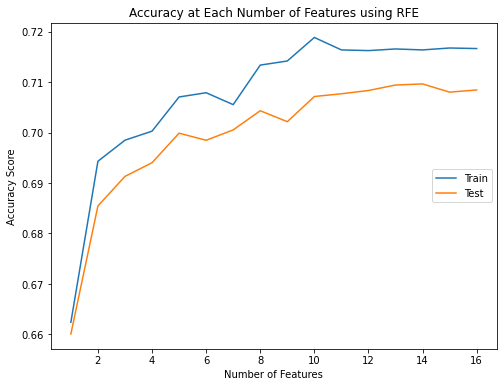

In [27]:
plt.figure(figsize=(8,6))
plt.plot(range(1, X_train.shape[1] + 1), train_acc, label='Train')
plt.plot(range(1, X_train.shape[1] + 1), test_acc, label='Test')
plt.xlabel("Number of Features")
plt.ylabel("Accuracy Score")
plt.title("Accuracy at Each Number of Features using RFE")
plt.legend(loc='center right')

The above graph visualizes the accuracy for a number of features. It appears that the most effective number of features are between 5 and 16. However, the difference in accuracy between 5 and 16 features is less than 1%. Therefore, the optimal model will contain only 5 features.

In [28]:
lr = LogisticRegression(max_iter=1000)
rfe = RFE(estimator=lr, n_features_to_select=5, step=1)
rfe.fit(X_train, y_train)

RFE(estimator=LogisticRegression(max_iter=1000), n_features_to_select=5)

In [29]:
lr_feats = list(X_train.columns[rfe.support_])
print(lr_feats)

['AGE', 'SERVICE_TENURE', 'PLAN_TENURE', 'MONTHS_OF_CONTRACT_REMAINING', 'MONTHLY_SPEND']


The 5 features are the recommended features are: 

- AGE 
- SERVICE_TENURE 
- PLAN_TENURE 
- MONTHS_OF_CONTRACT_REMAINING 
- MONTHLY_SPEND 

## Model Evaluation 

To evaluate the optimal model, the following evlauation uses Cross Validation and a Confusion Matrix to determine the average performance for the above selected optimal model.

In [30]:
train_preds = rfe.predict(X_train)
test_preds = rfe.predict(X_test)
print("Train accuracy:")
print(accuracy_score(y_train, train_preds))
print("Test accuracy:")
print(accuracy_score(y_test, test_preds))

Train accuracy:
0.7070427878492264
Test accuracy:
0.6998699327986126


Based on the accuracies recorded above, there apears to be no overfitting of the model

### Cross Validation

In [31]:
cv_score = cross_val_score(rfe, X_all, y_all, scoring='accuracy', cv=KFold(n_splits=10, shuffle=True))
print("Accuracy: %0.2f (+/- %0.2f)" % (cv_score.mean(), cv_score.std() * 2))

Accuracy: 0.71 (+/- 0.01)


In [32]:
cv_predict = cross_val_predict(rfe, X_all, y_all, cv=KFold(n_splits=10, shuffle=True))
print(classification_report(y_all, cv_predict, target_names=["Outcome = 0", "Outcome = 1"]))

              precision    recall  f1-score   support

 Outcome = 0       0.74      0.81      0.77     28366
 Outcome = 1       0.64      0.54      0.58     17763

    accuracy                           0.71     46129
   macro avg       0.69      0.67      0.68     46129
weighted avg       0.70      0.71      0.70     46129



Based on the Cross Validation the overall performance is consistant with unseen data with an average accuracy of 71% 

### Confusion Matrix

In [33]:
def confMatrix(data, length):
    trueNeg = "True Neg\n %0.2d\n %0.2f%%" % (data[0][0], data[0][0] / length * 100)
    falsePos = "False Pos\n %0.2d\n %0.2f%%" % (data[0][1], data[0][1] / length * 100)
    falseNeg = "False Neg\n %0.2d\n %0.2f%%" % (data[1][0], data[1][0] / length * 100)
    truePos = "True Pos\n %0.2d\n %0.2f%%" % (data[1][1], data[1][1] / length * 100)
    labels = np.array([[trueNeg, falsePos], [falseNeg, truePos]])
    return sns.heatmap(data=data, cmap="coolwarm", annot=labels, fmt='')

In [34]:
lr_confMatrix = confusion_matrix(y_all, cv_predict)

Text(0.5, 1.0, 'Logistic Regression Confution Matrix')

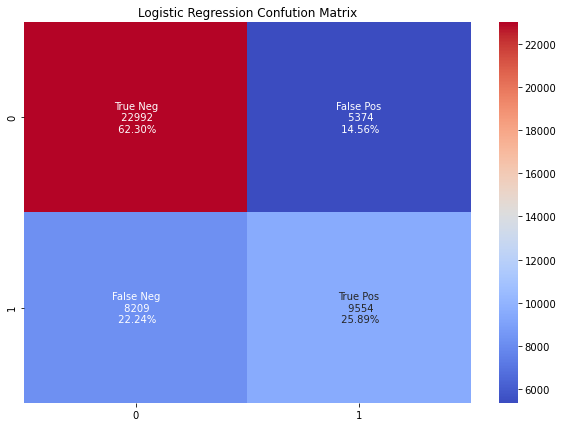

In [35]:
plt.figure(figsize=(10,7))
trainMatrix = confMatrix(lr_confMatrix, len(train_preds))
trainMatrix.set_title('Logistic Regression Confution Matrix')

As per the matrix above, the true positive and true negative predictions are high with false negatives of 22.24% and false positives of 14.56%

## K Nearest Neighbors Model

The next model to be evaluated it the K Nearest Neighbors Classifier. The following process will be carried out to determine its performance:  

1. Initial Creation and Accuracy 
2. Grid Search Cross Validation  
3. Cross Validation Accuracy Report
4. Confution Matrix

### Initial Creation and Accuracy

In [36]:
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)
y_preds = knn.predict(X_test)

In [37]:
print("Train accuracy:")
print(accuracy_score(y_train, train_preds))
print("Test accuracy:")
print(accuracy_score(y_test, test_preds))

Train accuracy:
0.7070427878492264
Test accuracy:
0.6998699327986126


With the initial model created with a nearest neighbours parameter of 5, there appears to be no under or over fitting.

### Grid Search Cross Validation

In [38]:
knn = KNeighborsClassifier()
parameters = {'n_neighbors': range(1, 100, 5)}

gridSearch = GridSearchCV(knn, parameters, scoring='accuracy', cv=KFold(n_splits=10, shuffle=True))
gridSearch.fit(X_all, y_all)

GridSearchCV(cv=KFold(n_splits=10, random_state=None, shuffle=True),
             estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': range(1, 100, 5)}, scoring='accuracy')

In [39]:
print("GS Best Parameters: ", gridSearch.best_params_)
print("With Accuracy: ", gridSearch.best_score_)

GS Best Parameters:  {'n_neighbors': 21}
With Accuracy:  0.6968934375851346


The Grid Search has determined that the best parameters are 36 neighbours with an accuracy of around 70% 

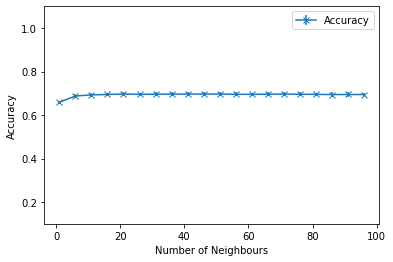

In [40]:
plt.errorbar(range(1, 100, 5), gridSearch.cv_results_['mean_test_score'], 
             yerr=gridSearch.cv_results_['std_test_score'], marker='x', label='Accuracy')
plt.ylim([0.1, 1.1])
plt.xlabel('Number of Neighbours')
plt.ylabel('Accuracy')
plt.legend(loc='best')
plt.show()

Based on the bar graph above, the accuracy of the model is very consistant from 10 neighbors up to 99

### Cross Validation Report

In [41]:
cv_predict = gridSearch.predict(X_all)

In [42]:
print(classification_report(y_all, cv_predict, target_names=["Outcome = 0", "Outcome = 1"]))

              precision    recall  f1-score   support

 Outcome = 0       0.74      0.85      0.80     28366
 Outcome = 1       0.69      0.53      0.60     17763

    accuracy                           0.73     46129
   macro avg       0.72      0.69      0.70     46129
weighted avg       0.72      0.73      0.72     46129



Based on the Cross Validation the overall performance is consistant with unseen data with an average accuracy of 72% 

### Confusion Matrix

In [43]:
knn_confMatrix = confusion_matrix(y_all, cv_predict)

Text(0.5, 1.0, 'K Nearest Neighbors Confution Matrix')

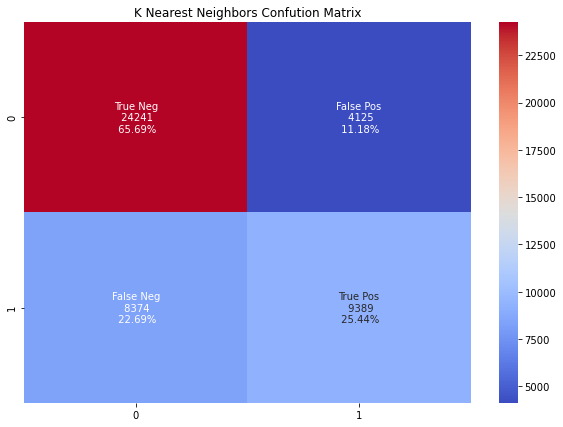

In [44]:
plt.figure(figsize=(10,7))
trainMatrix = confMatrix(knn_confMatrix, len(train_preds))
trainMatrix.set_title('K Nearest Neighbors Confution Matrix')

As per the matrix above, the true positive and true negative predictions are reasonable with false negatives of 22.69% and false positives of 11.18%

## Random Forest Model

The final model to be evaluated it the Random Forest Classifier. The following process will be carried out to determine its performance:  

1. Initial Creation and Accuracy 
2. Grid Search Cross Validation  
3. Cross Validation Accuracy Report
4. Confution Matrix

*Note: sklearn's Random Forest Classifies defult number of trees is 100*

### Initial Creation and Accuracy

In [45]:
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)
y_preds = rf.predict(X_test)

In [46]:
print("Train accuracy:")
print(accuracy_score(y_train, train_preds))
print("Test accuracy:")
print(accuracy_score(y_test, test_preds))

Train accuracy:
0.7070427878492264
Test accuracy:
0.6998699327986126


Initial model with it's default number of trees, appears to produce no under or over fitting.

### Grid Search Cross Validation

In [47]:
rf = RandomForestClassifier(random_state=42, max_depth=10)
parameters = {'n_estimators': range(100, 200, 10)}

gridSearch = GridSearchCV(rf, parameters, scoring='accuracy', cv=KFold(n_splits=10, shuffle=True))
gridSearch.fit(X_all, y_all)

GridSearchCV(cv=KFold(n_splits=10, random_state=None, shuffle=True),
             estimator=RandomForestClassifier(max_depth=10, random_state=42),
             param_grid={'n_estimators': range(100, 200, 10)},
             scoring='accuracy')

In [48]:
print("GS Best Parameters: ", gridSearch.best_params_)
print("With Accuracy: ", gridSearch.best_score_)

GS Best Parameters:  {'n_estimators': 180}
With Accuracy:  0.764226316366376


The Grid Search has determined that the best parameters are 180 trees with an accuracy of around 76%

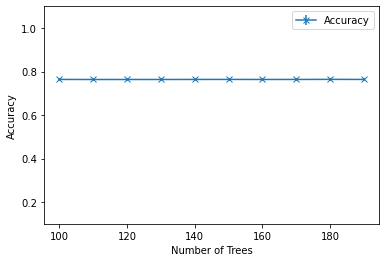

In [59]:
plt.errorbar(range(100, 200, 10), gridSearch.cv_results_['mean_test_score'], 
             yerr=gridSearch.cv_results_['std_test_score'], marker='x', label='Accuracy')
plt.ylim([0.1, 1.1])
plt.xlabel('Number of Trees')
plt.ylabel('Accuracy')
plt.legend(loc='best')
plt.show()

Based on the bar graph above, the accuracy of the model is very consistant from 100 neighbors up to 200

### Cross Validation Accuracy Report

In [54]:
cv_predict = gridSearch.predict(X_all)

In [56]:
print(classification_report(y_all, cv_predict, target_names=["Outcome = 0", "Outcome = 1"]))

              precision    recall  f1-score   support

 Outcome = 0       0.79      0.90      0.84     28366
 Outcome = 1       0.80      0.61      0.69     17763

    accuracy                           0.79     46129
   macro avg       0.79      0.76      0.77     46129
weighted avg       0.79      0.79      0.78     46129



Based on the Cross Validation the overall performance is consistant with unseen data with an average accuracy of 79%

### Confution Matrix

In [57]:
rf_confMatrix = confusion_matrix(y_all, cv_predict)

Text(0.5, 1.0, 'Random Forest Confution Matrix')

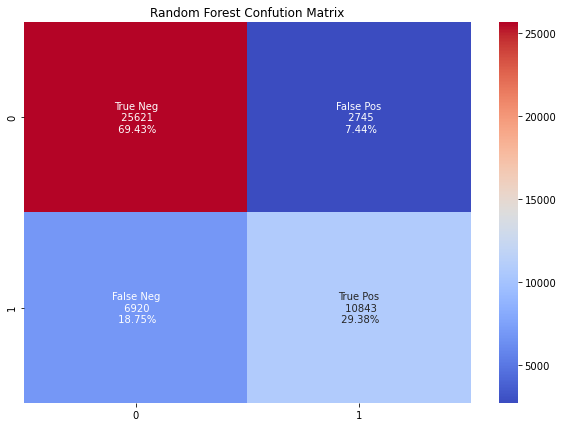

In [58]:
plt.figure(figsize=(10,7))
trainMatrix = confMatrix(rf_confMatrix, len(train_preds))
trainMatrix.set_title('Random Forest Confution Matrix')

As per the matrix above, the true positive and true negative predictions are high with false negatives of 18.75% and false positives of 7.44%

# Conclusion 

Based on the evaluations above, the Random Forest Classifier with the number of trees appears to be the better performer out of the three models tested. 

The training and testing accuracy shows no sign of over and under fitting with an accuracy of around 71% training accuracy and 70% testing accuracy.  

Based on the cross validation test, the average accuracy accross 10 fold's is 79% with 180 trees which is higher than that of the inital grid search accuracy scoring of 76%. This provided confidence that the model will perform will with unseen data. 

The confusion matrix evaluated a reasonable ratio of false negatives of 18.75% and false positives of 7.44%. However in the context of business use an 18.75% may be seen as too high of a loss by a business that was unable to identify potential customers leaving their services. Although the false positive of 7.44% may be reasonable with only a small portion the businesses customers predicted to leave their services without the actual intent to do so. 

With the Random Forest Classifier created and evaluated, the model seems like a good canditate to be used in a live setting. However, with the results obtained with the confusion matrix and accuracy scores, futher tuning and test should be carried out before hand. 